# Continuous Control - Deep Deterministic Policy Gradienty (DDPG)

---

### 1. Start the Environment

In [1]:
from unityagents import UnityEnvironment

import numpy as np
import random
from collections import deque

import torch

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# environment configuration
env = UnityEnvironment(file_name="Reacher_Linux_20/Reacher.x86_64", no_graphics=False)

brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

In [3]:
# environment information
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]
# number of agents in the environment
n_agents = len(env_info.agents)
print('Number of agents:', n_agents)
# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)
# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 20
Number of actions: 4
States look like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]
States have length: 33


### 3. Agent Setup

In [4]:

import copy
import os
from collections import namedtuple
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from model_y import Actor, Critic



class Agent():        
    def __init__(self, 
        device,
        state_size, n_agents, action_size, random_seed,
        buffer_size, batch_size, gamma, TAU, lr_actor, lr_critic, weight_decay,
        checkpoint_folder = './'):        

        self.DEVICE = device

        self.state_size = state_size
        self.n_agents = n_agents
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Hyperparameters
        self.BUFFER_SIZE = buffer_size
        self.BATCH_SIZE = batch_size
        self.GAMMA = gamma
        self.TAU = TAU
        self.LR_ACTOR = lr_actor
        self.LR_CRITIC = lr_critic
        self.WEIGHT_DECAY = weight_decay

        self.CHECKPOINT_FOLDER = checkpoint_folder

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(self.DEVICE)
        self.actor_target = Actor(state_size, action_size, random_seed).to(self.DEVICE)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=self.LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(self.DEVICE)
        self.critic_target = Critic(state_size, action_size, random_seed).to(self.DEVICE)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=self.LR_CRITIC, weight_decay=self.WEIGHT_DECAY)
        
        # multiple agent
        if os.path.isfile(self.CHECKPOINT_FOLDER + 'checkpoint_actor.pth') and os.path.isfile(self.CHECKPOINT_FOLDER + 'checkpoint_critic.pth'):
            self.actor_local.load_state_dict(torch.load(self.CHECKPOINT_FOLDER + 'checkpoint_actor.pth'))
            self.actor_target.load_state_dict(torch.load(self.CHECKPOINT_FOLDER + 'checkpoint_actor.pth'))

            self.critic_local.load_state_dict(torch.load(self.CHECKPOINT_FOLDER + 'checkpoint_critic.pth'))
            self.critic_target.load_state_dict(torch.load(self.CHECKPOINT_FOLDER + 'checkpoint_critic.pth'))
        
        '''
        # single agent
        if os.path.isfile(self.CHECKPOINT_FOLDER + 'checkpoint_actor_single.pth') and os.path.isfile(self.CHECKPOINT_FOLDER + 'checkpoint_critic_single.pth'):
            self.actor_local.load_state_dict(torch.load(self.CHECKPOINT_FOLDER + 'checkpoint_actor_single.pth'))
            self.actor_target.load_state_dict(torch.load(self.CHECKPOINT_FOLDER + 'checkpoint_actor_single.pth'))

            self.critic_local.load_state_dict(torch.load(self.CHECKPOINT_FOLDER + 'checkpoint_critic_single.pth'))
            self.critic_target.load_state_dict(torch.load(self.CHECKPOINT_FOLDER + 'checkpoint_critic_single.pth'))        
        '''
        
        # Noise process
        self.noise = OUNoise((n_agents, action_size), random_seed)

        # Replay memory
        self.memory = ReplayBuffer(device, action_size, self.BUFFER_SIZE, self.BATCH_SIZE, random_seed)
    
    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        for i in range(self.n_agents):
            self.memory.add(state[i,:], action[i,:], reward[i], next_state[i,:], done[i])

        # Learn, if enough samples are available in memory        
        if len(self.memory) > self.BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(self.DEVICE)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()        
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (self.GAMMA * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        # torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target)
        self.soft_update(self.actor_local, self.actor_target)   
           
        self.actor_loss = actor_loss.data
        self.critic_loss = critic_loss.data        

    def soft_update(self, local_model, target_model):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        tau = self.TAU
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    def checkpoint(self):
        # single agent
        torch.save(self.actor_local.state_dict(), self.CHECKPOINT_FOLDER + 'checkpoint_actor_single.pth')      
        torch.save(self.critic_local.state_dict(), self.CHECKPOINT_FOLDER + 'checkpoint_critic_single.pth')
        '''
        # multiple agent
        torch.save(self.actor_local.state_dict(), self.CHECKPOINT_FOLDER + 'checkpoint_actor.pth')      
        torch.save(self.critic_local.state_dict(), self.CHECKPOINT_FOLDER + 'checkpoint_critic.pth')
        '''
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.size = size        
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma        
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state        
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, device, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.DEVICE = device

        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""        
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(self.DEVICE)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(self.DEVICE)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(self.DEVICE)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(self.DEVICE)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.DEVICE)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### 4. Train the Agent

In [5]:
#from yeom_agent import Agent

# hyperparameters
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-4        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

CHECKPOINT_FOLDER = './'


agent = Agent(
                DEVICE, 
                state_size, n_agents, action_size, 4, 
                BUFFER_SIZE, BATCH_SIZE, GAMMA, TAU, LR_ACTOR, LR_CRITIC, WEIGHT_DECAY,
                CHECKPOINT_FOLDER
        )

#agent = Agent(state_size = state_size, n_agents = n_agents, action_size = action_size, random_seed = 4)


Episode: 	0 	Score: 	35.39 	Average Score: 	35.39
Environment solved in 0 episodes!	Average Score: 35.39


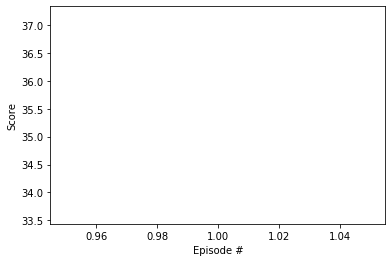

In [6]:
def ddpg_train():
    scores = []
    scores_window = deque(maxlen=100)
    n_episodes = 1000

    for episode in range(n_episodes):
        env_info = env.reset(train_mode=True)[brain_name]            # reset the environment
        states = env_info.vector_observations
        agent.reset()                                                # reset the agent noise
        score = np.zeros(n_agents)
        
        while True:
            actions = agent.act(states)
        
            env_info = env.step( actions )[brain_name]               # send the action to the environment                            
            next_states = env_info.vector_observations               # get the next state        
            rewards = env_info.rewards                               # get the reward        
            dones = env_info.local_done                              # see if episode has finished        

            agent.step(states, actions, rewards, next_states, dones)

            score += rewards                                         # update the score
        
            states = next_states                                     # roll over the state to next time step        
                                                        
            if np.any( dones ):                                          # exit loop if episode finished        
                break                                        

        agent.checkpoint()

        scores.append(np.mean(score))
        scores_window.append(np.mean(score))

        print('\rEpisode: \t{} \tScore: \t{:.2f} \tAverage Score: \t{:.2f}'.format(episode, np.mean(score), np.mean(scores_window)), end="")  
        
        if np.mean(scores_window) >= 30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)))
            break    

    plt.plot(np.arange(1, len(scores)+1), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()    


# train the agent
ddpg_train()

This graph doesn't show train result(because pre-trained model is applicated)

Result of training is attached in file!!

### 5. Test the Agent

In [7]:
# test the trained agent

agent = Agent(
                DEVICE, 
                state_size, n_agents, action_size, 4, 
                BUFFER_SIZE, BATCH_SIZE, GAMMA, TAU, LR_ACTOR, LR_CRITIC, WEIGHT_DECAY,
                CHECKPOINT_FOLDER
        )

for episode in range(1):
    env_info = env.reset(train_mode=False)[brain_name]        
    states = env_info.vector_observations       
    score = np.zeros(n_agents)               
    
    while True:
        actions = agent.act(states, add_noise=False)                    
        
        env_info = env.step(actions)[brain_name]        
        next_states = env_info.vector_observations     
        rewards = env_info.rewards       
        dones = env_info.local_done
        score += rewards
        states = next_states

        if np.any(dones):                              
            break

    print('Episode: \t{} \tScore: \t{:.2f}'.format(episode, np.mean(score)))      


Episode: 	0 	Score: 	31.25


In [8]:
env.close()